# Exercise 7: Matching

**Summer Semester 2025**

**Author**: Stefan Baumann (stefan.baumann@lmu.de)

## Instructions

Parts where code should be added are marked using `TODO Student` and `END Student`. Add your code between these markers but leave them in the code. There should be no need to change code outside of these spans besides imports. Similarly, space for answering the three free-text questions is provided in the markdown and also marked by `TODO Student`.

*Please* add extensive comments to your code to explain what you're doing/trying to do. It is hard to assign partial points for incorrect or incomplete solutions if we do not understand what you are trying to do.

For the third part of this exercise, we recommend using a GPU, although it is not required. We verified that the exercise can be solved on Nvidia GPUs, Apple Silicon GPUs (an M3 Pro can run the whole reference solution in ~5s), and CPU-only setups.

In [18]:
import math
import albumentations as A
import numpy as np
import torch
import torch.nn.functional as F
from torchvision.io import read_video
from torchvision.utils import flow_to_image 
from torchvision import transforms as T
from skimage.feature import plot_matched_features, SIFT, match_descriptors
from skimage.transform import warp
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from einops import rearrange 
from skimage import io


device = "mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device "{device}".')

Using device "mps".


## Task 1: Image Matching

### SIFT & Matching

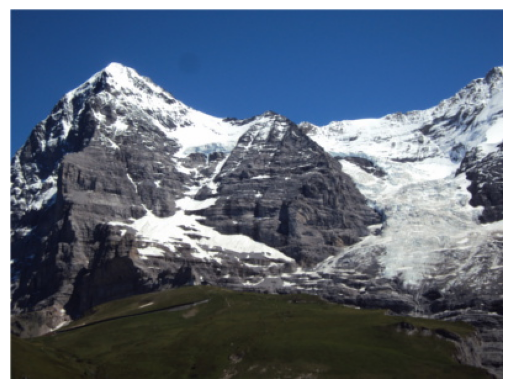

In [29]:
img = cv2.imread("/Users/ryanqchiqache/PycharmProjects/Machine-Learning-Learning-Center/ComputerVisionCourse/Exercise07/data/view0.jpg")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
transform_img = A.Compose([
    A.RandomRotate90(p=1.0)
])
tensor_img = transform_img(image=img_rgb)
img_aug = tensor_img["image"]

plt.imshow(img_aug)
plt.axis("off")
plt.show()


Extracted keypoints from image 0: (1377, 2)
Extracted keypoints from image 1: (1667, 2)
Descriptor shape from image 0: (1377, 128)
Descriptor shape from image 1: (1667, 128)


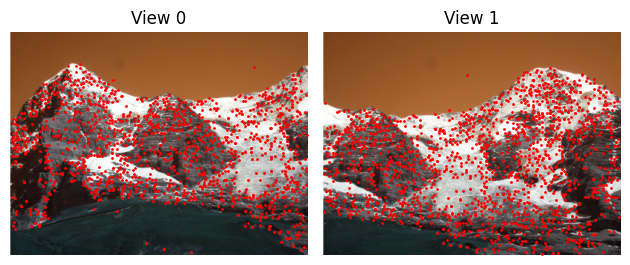

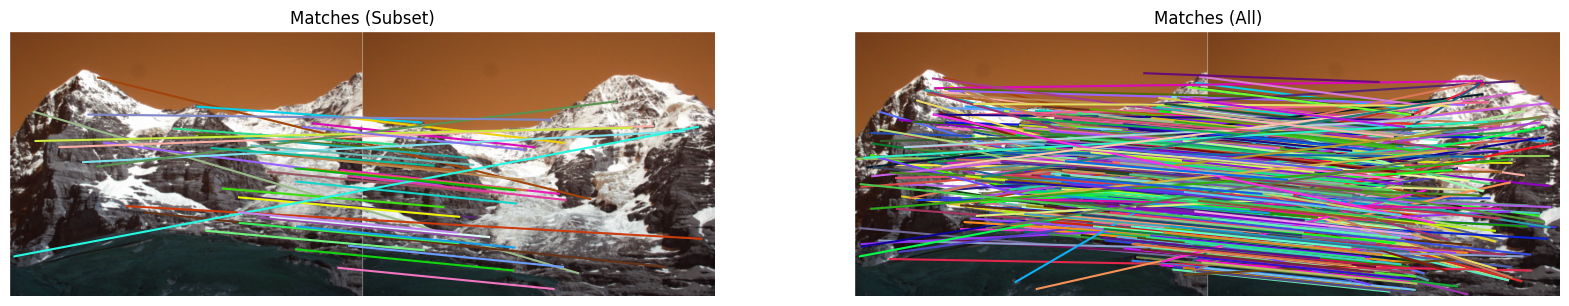

In [27]:
# TODO Student: Load images and extract features using SIFT
# Variables to use: view0, view1 (both shape H W C), keypoints0, keypoints1 (both shape N 2)
view0 = cv2.imread("/Users/ryanqchiqache/PycharmProjects/Machine-Learning-Learning-Center/ComputerVisionCourse/Exercise07/data/view0.jpg")
view1 = cv2.imread("/Users/ryanqchiqache/PycharmProjects/Machine-Learning-Learning-Center/ComputerVisionCourse/Exercise07/data/view1.jpg")

gray0 = cv2.cvtColor(view0, cv2.COLOR_RGB2GRAY)
gray1 = cv2.cvtColor(view1, cv2.COLOR_RGB2GRAY)

sift0 = SIFT()
sift1 = SIFT()

sift0.detect_and_extract(gray0)
sift1.detect_and_extract(gray1)

# Where is it? and  What does it look like?
keypoints0 = sift0.keypoints  # shape (N0, 2)
keypoints1 = sift1.keypoints  # shape (N1, 2)
descriptors0 = sift0.descriptors  # shape (N0, 128)
descriptors1 = sift1.descriptors  # shape (N1, 128)

print(f"Extracted keypoints from image 0: {keypoints0.shape}")
print(f"Extracted keypoints from image 1: {keypoints1.shape}")
print(f"Descriptor shape from image 0: {descriptors0.shape}")
print(f"Descriptor shape from image 1: {descriptors1.shape}")
# END Student
plt.subplot(1, 2, 1)
plt.title("View 0")
plt.imshow(view0)
plt.scatter(keypoints0[:, 1], keypoints0[:, 0], color="red", s=1)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("View 1")
plt.imshow(view1)
plt.scatter(keypoints1[:, 1], keypoints1[:, 0], color="red", s=1)
plt.axis("off")

plt.tight_layout()
plt.show()

# TODO Student: Detect matches
# Variables to use: matches (shape M 2)
matches = match_descriptors(descriptors0, descriptors1, cross_check=True) #find correspondences between image00 and image01 with cross_check for best match
# END Student

plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.title("Matches (Subset)")
plot_matched_features(
    view0,
    view1,
    keypoints0=keypoints0,
    keypoints1=keypoints1,
    matches=matches[::20],
    ax=plt.gca(),
    only_matches=True,
)
plt.axis("off")
plt.subplot(1, 2, 2)
plt.title("Matches (All)")
plot_matched_features(
    view0,
    view1,
    keypoints0=keypoints0,
    keypoints1=keypoints1,
    matches=matches,
    ax=plt.gca(),
    only_matches=True,
)
plt.axis("off")
plt.show()

In [4]:
print(f"Total matches found: {matches.shape[0]}")
print(f"Matches array shape: {matches.shape}")
print(f"First 5 matches:\n{matches[:5]}")

Total matches found: 798
Matches array shape: (798, 2)
First 5 matches:
[[   3  654]
 [   9   84]
 [  11 1036]
 [  13  994]
 [  16    7]]


To fit an affine transformation to the matched keypoints we need to convert our problem into a linear equation system.
The general format of an affine transformation
$$
	\begin{pmatrix}
		x_t\\
		y_t
	\end{pmatrix}=
	\begin{pmatrix}
		s_{11} & s_{12}\\
		s_{21} & s_{22}
	\end{pmatrix}\cdot
	\begin{pmatrix}
		x_s\\
		y_s
	\end{pmatrix}+
	\begin{pmatrix}
		t_1\\
		t_2
	\end{pmatrix}
	=\mathbf{A}{\mathbf{x}_s}+{\mathbf{t}}
$$
can be represented as the following format:
$$
\begin{pmatrix}
 & & \dotsm\\
x_{i,s} & y_{i,s} & 1 & 0 & 0 & 0\\
0 & 0 & 0 & x_{i,s} & y_{i,s} & 1\\
& & \dotsm
\end{pmatrix}
\cdot
\begin{pmatrix}
s_{11}\\
s_{12}\\
t_1\\
s_{21}\\
s_{22}\\
t_2
\end{pmatrix}
= 
\begin{pmatrix}
\dotsm\\
x_{i,t}\\
y_{i,t}\\
\dotsm
\end{pmatrix}
$$

To solve the system $\mathbf{A}\mathbf{x}=\mathbf{b}$ for $\mathbf{x}$, we can use the Moore-Penrose pseudo-inverse $\mathbf{A}^\dagger$ of $\mathbf{A}$ to obtain the least-squares solution. For our solution then holds
$$
\mathbf{x}=\mathbf{A}^\dagger\cdot\mathbf{b}=\left(\mathbf{A}^\intercal\mathbf{A}\right)^{-1}\mathbf{A}^\intercal\mathbf{b}
$$

## Affine Solving

In [5]:
def solve_affine(source_points, target_points, verbose = True):
    """Solve the affine transformation matrix from source to target points.

    Args:
        source_points (np.ndarray): shape (N, 2)
        target_points (np.ndarray): shape (N, 2)

    Returns:
        np.ndarray: affine transform as homogeneous matrix of shape (3, 3)
        (top left 2x2 contains the scale matrix, top right 2x1 contains the translation vector, bottom row is [0, 0, 1])
        :param source_points: (N,2)
        :param target_points: (N,2)
        :param verbose: Bool
    """
    assert len(source_points) == len(target_points), "Source and target points should have the same cardinality"
    N = len(source_points)

    # TODO Student
    source_aug = np.hstack([source_points, np.ones((N, 1))])  # (N, 3)
    A, residuals, rank, singular_values = np.linalg.lstsq(source_aug, target_points, rcond=None)

    if verbose:
        print("=== Solving Affine Transformation ===")
        print(f"Source augmented shape: {source_aug.shape}")
        print(f"A (3x2):\n{A}")
        print(f"Residuals: {residuals}")
        print(f"Rank: {rank}")
        print(f"Singular values: {singular_values}")

    affine_matrix = np.eye(3) # (3x3) identity matrix apparently...is it for testing ?? since we usually don't do that 
    affine_matrix[:2, :] = A.T
    return affine_matrix
    

    return affine_matrix

    # END Student


def transform_affine(points, mat):
    """Transform points using an affine transformation matrix.

    Args:
        points (np.ndarray): shape (N, 2)
        mat (np.ndarray): affine transform as homogeneous matrix of shape (3, 3)

    Returns:
        np.ndarray: transformed points of shape (N, 2)
    """
    return np.einsum("ij,nj->ni", mat[:2], np.concatenate([points, np.ones((len(points), 1))], axis=-1))


# Unit Test: use a known transformation matrix to warp points and then solve for the matrix again
# DO NOT CHANGE!
# In case of a partial solution, the test will fail, but do not disable it.
test_mat = np.array([[0.5, 0.5, 1.0], [0.5, 0.5, 1.0], [0.0, 0.0, 1.0]])
test_source = np.array([[0.0, -1.0], [0.2, -0.3], [1.0, 1.7]])

test_mat_pred = solve_affine(test_source, transform_affine(test_source, test_mat))
assert np.allclose(test_mat, test_mat_pred), "The predicted transformation matrix does not match the original."
print("Unit test passed.")

=== Solving Affine Transformation ===
Source augmented shape: (3, 3)
A (3x2):
[[0.5 0.5]
 [0.5 0.5]
 [1.  1. ]]
Residuals: []
Rank: 3
Singular values: [2.2570371  1.70998975 0.04145604]
Unit test passed.


## Visualization

=== Solving Affine Transformation ===
Source augmented shape: (798, 3)
A (3x2):
[[7.88867810e-01 5.56671860e-02]
 [2.20855814e-02 1.66458557e-02]
 [4.97927749e+01 1.46560002e+02]]
Residuals: [ 960720.30257184 6912834.08858635]
Rank: 3
Singular values: [8.80273386e+03 1.73328093e+03 6.98347625e+00]
Estimated affine transformation matrix: [[7.88867810e-01 2.20855814e-02 4.97927749e+01]
 [5.56671860e-02 1.66458557e-02 1.46560002e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


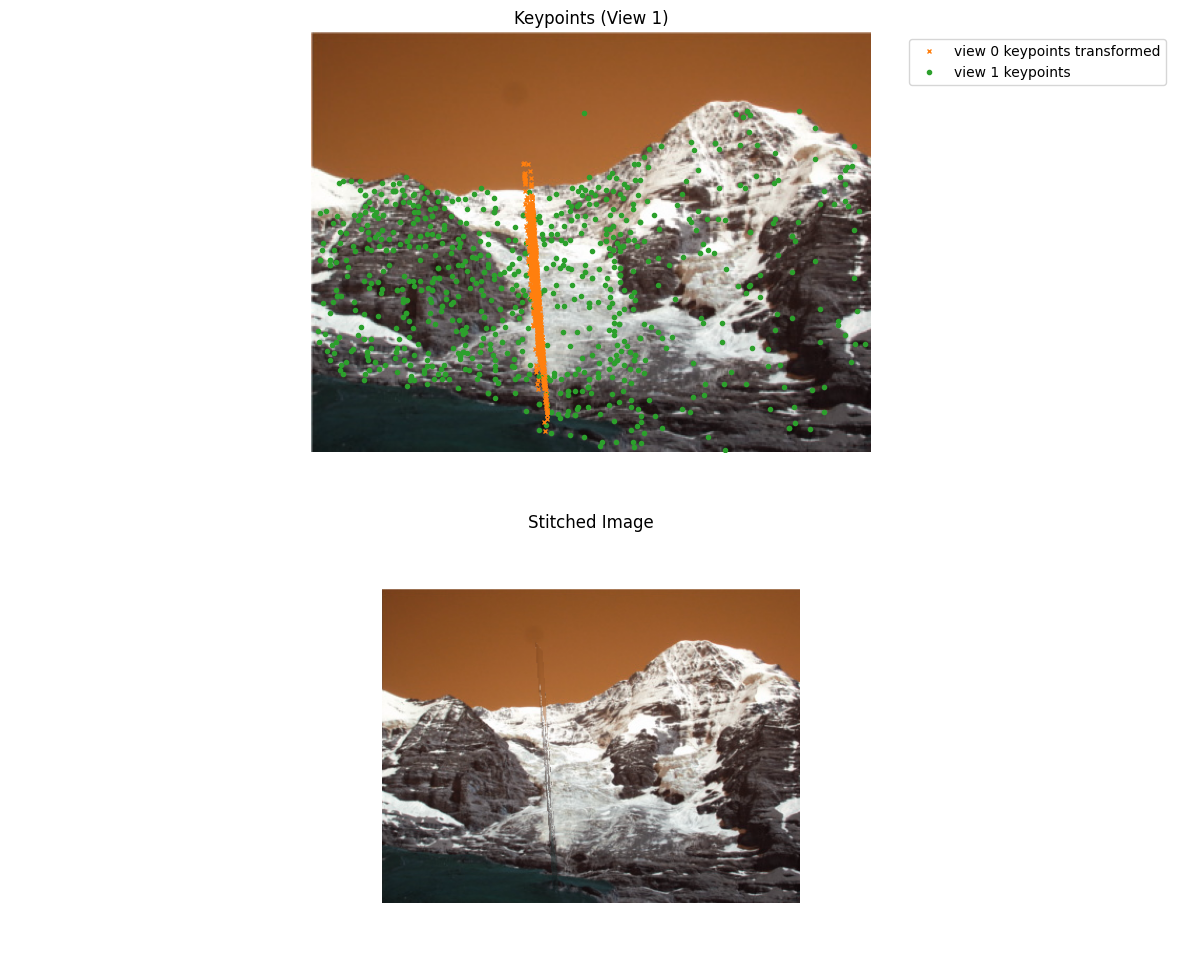

In [6]:
source_matched = keypoints0[matches[:, 0]]
target_matched = keypoints1[matches[:, 1]]

affine_mat = solve_affine(source_matched, target_matched)
print("Estimated affine transformation matrix:", affine_mat)

# Transform source points to target points
transformed = transform_affine(source_matched, affine_mat)


# Plot the results
plt.figure(figsize=(15, 12))

plt.subplot(2, 1, 1)
plt.title("Keypoints (View 1)")
plt.imshow(view1)
plt.plot(
    transformed[:, 1],
    transformed[:, 0],
    marker="x",
    markersize=3,
    linewidth=0,
    c="C1",
    label="view 0 keypoints transformed",
    zorder=10,
)
plt.plot(
    target_matched[:, 1],
    target_matched[:, 0],
    marker="o",
    markersize=3,
    linewidth=0,
    c="C2",
    label="view 1 keypoints",
)
plt.legend()
plt.axis("equal")
plt.axis("off")

plt.subplot(2, 1, 2)
plt.title("Stitched Image")
padx = 200
pady = 50
out_shape = (view1.shape[0] + 2 * pady, view1.shape[1] + 2 * padx)
# Compute transform for warping
# Warping uses a different coordinate convention, so we convert first, also accounting for padding
hmat = np.array(
    [
        [affine_mat[1, 1], affine_mat[1, 0], affine_mat[1, 2]],
        [affine_mat[0, 1], affine_mat[0, 0], affine_mat[0, 2]],
        [0.0, 0.0, 1.0],
    ]
)
glob_mat = np.array([[1.0, 0.0, padx], [0.0, 1.0, pady], [0.0, 0.0, 1.0]])
warp_mat = np.linalg.inv(glob_mat @ hmat)
# Warp the first image and stitch it with the second image
warped = warp(view0, warp_mat, output_shape=out_shape, cval=np.inf)
warp_valid = np.isfinite(warped[pady:-pady, padx:-padx])
warped[pady:-pady, padx:-padx][~warp_valid] = (view1 / 255)[~warp_valid]
warped[pady:-pady, padx:-padx][warp_valid] = (warped[pady:-pady, padx:-padx] / 2 + view1 / 510)[warp_valid]
plt.imshow(warped)
plt.axis("off")

plt.show()

---
**Describe what you see. Does the transformation look good?**

TODO Student

---

## Task 2: Robust Affine Transformation with RANSAC

=== Solving Affine Transformation ===
Source augmented shape: (3, 3)
A (3x2):
[[ 9.92937378e-01 -2.50891236e-02]
 [ 4.62769893e-02  1.00248873e+00]
 [ 1.25311764e+01 -1.47760678e+02]]
Residuals: []
Rank: 3
Singular values: [5.84719775e+02 1.39756041e+02 1.81930272e-01]
Estimated transformation matrix: [[ 9.92937378e-01  4.62769893e-02  1.25311764e+01]
 [-2.50891236e-02  1.00248873e+00 -1.47760678e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]


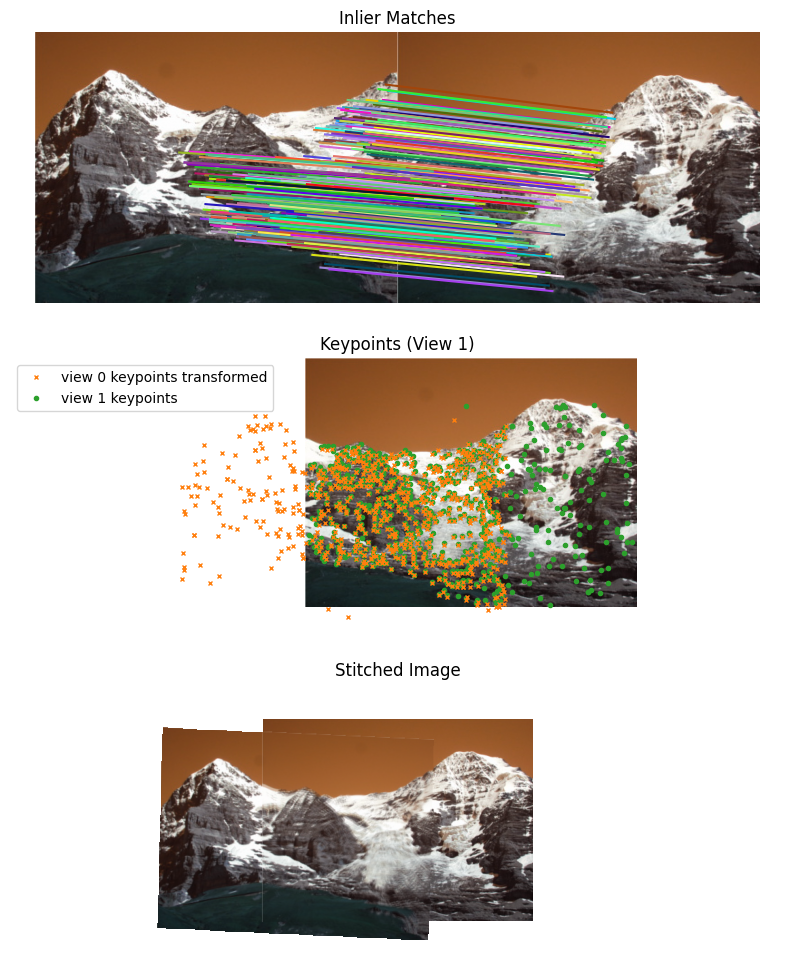

In [7]:
class RANSAC:
    def __init__(
        self,
        inlier_probability: float = 0.99,
        outlier_ratio: float = 0.1,
        max_iterations: int = 1e4,
        threshold: float = 1.0,
        min_consensus_size: int = 100,
    ):
        self.inlier_probability = inlier_probability
        self.outlier_ratio = outlier_ratio
        self.min_points_required = 3
        self.max_iterations = max_iterations
        self.threshold = threshold
        self.min_consensus_size = min_consensus_size

        self.best_mat = None
        self.inlier_indices = None

    def find_inliers(self, source_points, target_points, mat):
        """Find inliers based on the current transformation matrix.

        Args:
            source_points (np.ndarray): shape (N, 2)
            target_points (np.ndarray): shape (N, 2)
            mat (np.ndarray): affine transform as homogeneous matrix of shape (3, 3)

        Returns:
            tuple: (transformation matrix (np.ndarray, shape (3, 3)), inlier indices (np.ndarray, shape (M,)))
        """
        assert len(source_points) == len(target_points), "Source and target points should have the same cardinality"

        # TODO Student
        projected = transform_affine(source_points, mat)  # shape (N, 2)
        distances = np.linalg.norm(projected - target_points, axis=1)  # shape (N,)
        inlier_indices = np.where(distances < self.threshold)[0]
        return mat, inlier_indices

        # END Student

    def fit(self, source_points, target_points):
        """Fit an affine transformation using RANSAC.

        Args:
            source_points (np.ndarray): shape (N, 2)
            target_points (np.ndarray): shape (N, 2)

        Returns:
            tuple: (best transformation matrix (np.ndarray, shape (3, 3)), inlier indices (np.ndarray, shape (M,)))
        """
        assert len(source_points) > self.min_points_required, "Not enough points to fit an affine transformation"
        assert len(source_points) == len(target_points), "Source and target points should have the same cardinality"

        # TODO Student
        N = len(source_points)
        best_inliers = []
        best_matrix = None
    
        for _ in range(int(self.max_iterations)):
            # Randomly choose 3 indices without replacement
            idx = np.random.choice(N, self.min_points_required, replace=False)
            sp_sample = source_points[idx]
            tp_sample = target_points[idx]
    
            # Estimate affine matrix
            try:
                mat = solve_affine(sp_sample, tp_sample)
            except np.linalg.LinAlgError:
                continue  # skip invalid matrices
    
            # Find inliers
            mat, inliers = self.find_inliers(source_points, target_points, mat)
    
            if len(inliers) > len(best_inliers):
                best_inliers = inliers
                best_matrix = mat
    
                # Early stop if large consensus found
                if len(inliers) > self.min_consensus_size:
                    break
    
        self.best_mat = best_matrix
        self.inlier_indices = best_inliers
        return best_matrix, best_inliers

        # END Student


source_matched = keypoints0[matches[:, 0]]
target_matched = keypoints1[matches[:, 1]]

# Fit affine transformation with RANSAC
# These parameters should lead to a good match for the given images, there should be no need to change them.
ransac = RANSAC(
    inlier_probability=0.99,
    outlier_ratio=0.4,
    threshold=2.0,
    min_consensus_size=10,
)
best_mat, inlier_indices = ransac.fit(source_matched, target_matched)
print("Estimated transformation matrix:", best_mat)

# Transform points
transformed = transform_affine(source_matched, best_mat)


# Plot the results
plt.figure(figsize=(10, 12))

plt.subplot(3, 1, 1)
plt.title("Inlier Matches")
m = np.concatenate([inlier_indices.reshape(-1, 1)] * 2, axis=-1)
plot_matched_features(
    view0,
    view1,
    keypoints0=source_matched,
    keypoints1=target_matched,
    matches=m,
    ax=plt.gca(),
    only_matches=True,
)
plt.axis("off")

plt.subplot(3, 1, 2)
plt.title("Keypoints (View 1)")
plt.imshow(view1)
plt.plot(
    transformed[:, 1],
    transformed[:, 0],
    marker="x",
    markersize=3,
    linewidth=0,
    c="C1",
    label="view 0 keypoints transformed",
    zorder=10,
)
plt.plot(
    target_matched[:, 1],
    target_matched[:, 0],
    marker="o",
    markersize=3,
    linewidth=0,
    c="C2",
    label="view 1 keypoints",
)
plt.legend()
plt.axis("equal")
plt.axis("off")

plt.subplot(3, 1, 3)
plt.title("Stitched Image")
padx = 200
pady = 50
out_shape = (view1.shape[0] + 2 * pady, view1.shape[1] + 2 * padx)
# Compute transform for warping
# Warping uses a different coordinate convention, so we convert first, also accounting for padding
hmat = np.array(
    [
        [best_mat[1, 1], best_mat[1, 0], best_mat[1, 2]],
        [best_mat[0, 1], best_mat[0, 0], best_mat[0, 2]],
        [0.0, 0.0, 1.0],
    ]
)
glob_mat = np.array([[1.0, 0.0, padx], [0.0, 1.0, pady], [0.0, 0.0, 1.0]])
warp_mat = np.linalg.inv(glob_mat @ hmat)
# Warp the first image and stitch it with the second image
warped = warp(view0, warp_mat, output_shape=out_shape, cval=np.inf)
warp_valid = np.isfinite(warped[pady:-pady, padx:-padx])
warped[pady:-pady, padx:-padx][~warp_valid] = (view1 / 255)[~warp_valid]
warped[pady:-pady, padx:-padx][warp_valid] = (warped[pady:-pady, padx:-padx] / 2 + view1 / 510)[warp_valid]
plt.imshow(warped)
plt.axis("off")

plt.show()

---
**Compare these results to the previous ones. What has changed, and why?**

TODO Student

---

## Task 3: Optical Flow-Based Image Warping

In [8]:
# Load video and convert to torch tensor
seq, _, _ = read_video("/Users/ryanqchiqache/PycharmProjects/Machine-Learning-Learning-Center/ComputerVisionCourse/Exercise07/data/video.mp4", pts_unit="sec")
"""cap = cv2.VideoCapture("/Users/ryanqchiqache/PycharmProjects/Machine-Learning-Learning-Center/ComputerVisionCourse/Exercise07/data/video.mp4")
frames = []

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frames.append(frame)

cap.release()
seq_np = np.stack(frames).astype(np.float32)
seq = torch.tensor(seq_np.copy())"""
seq = (seq / 255.0 - 0.5) / 0.5  # map to [-1, 1]
seq = rearrange(seq, "t h w c -> t c h w").to(device)
seq = F.interpolate(seq, (256, 256), mode="bilinear", antialias=True) # (t, c, h, w)
print(seq.dtype)


NotImplementedError: The operator 'aten::_upsample_bilinear2d_aa.out' is not currently implemented for the MPS device. If you want this op to be added in priority during the prototype phase of this feature, please comment on https://github.com/pytorch/pytorch/issues/77764. As a temporary fix, you can set the environment variable `PYTORCH_ENABLE_MPS_FALLBACK=1` to use the CPU as a fallback for this op. WARNING: this will be slower than running natively on MPS.

In [ ]:
# TODO Student: Load RAFT model
ransac_model = RANSAC()
# END Student

In [ ]:
@torch.no_grad()
def est_flow_and_warp(source, target):
    """Estimate optical flow (backward) and warp source to target using RAFT.

    Args:
        source (torch.Tensor): source image tensor of shape (B, C, H, W)
        target (torch.Tensor): target image tensor of shape (B, C, H, W)

    Returns:
        tuple: (warped source tensor of shape (B, C, H, W), backward flow tensor of shape (B, 2, H, W))
    """
    assert source.size() == target.size(), f"Source and target images must have the same shape."

    # TODO Student: Estimate optical flow

    # END Student

    return warped, flow


# Estimate flow from starting frame to every 30th frame
frameskip = 30
source = seq[:1].repeat(int(math.ceil(seq.size(0) / frameskip)), 1, 1, 1)
target = seq[::frameskip].clone()
warped, flow = est_flow_and_warp(source, target)

# Visualize the results
plt.figure(figsize=(20, 10))

plt.subplot(4, 1, 1)
plt.title("Source Frame")
plt.imshow((rearrange(source.cpu().numpy(), "t c h w -> h (t w) c") + 1) / 2)
plt.axis("off")

plt.subplot(4, 1, 2)
plt.title("Target Frame")
plt.imshow((rearrange(target.cpu().numpy(), "t c h w -> h (t w) c") + 1) / 2)
plt.axis("off")

plt.subplot(4, 1, 3)
plt.title("Estimated Flow (Backward Flow)")
plt.imshow(rearrange(flow_to_image(flow).cpu().numpy(), "t c h w -> h (t w) c") / 255.0)
plt.axis("off")

plt.subplot(4, 1, 4)
plt.title("Warped Frame (Approximation of Target Frame from Source Frame + Backward Flow)")
plt.imshow((rearrange(warped.cpu().numpy(), "t c h w -> h (t w) c") + 1) / 2)
plt.axis("off")

plt.show()

---
**Which artifacts can you see? Try to explain what caused them.**

TODO Student

---